In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Folder path
folder_path = Path.cwd().joinpath('data')

In [ ]:
## Read model data
model_data = pd.read_csv(folder_path.joinpath('model_data.csv'))
model_data.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,28.0,male,3.0,2013-12-23,186.0,23.0,13.0,10.0,318.0,348.0,80598.557
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36.0,30.0,180.0,180.0,0.0,2017-03-11,2017-04-11,0.0,13.0,20.0,male,3.0,2013-12-23,0.0,4.0,2.0,0.0,26.0,30.0,6986.509
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15.0,90.0,300.0,300.0,0.0,2017-03-14,2017-06-15,0.0,13.0,18.0,male,3.0,2013-12-27,239.0,57.0,32.0,22.0,205.0,432.0,67810.467
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41.0,30.0,149.0,149.0,1.0,2015-12-08,2017-12-08,0.0,1.0,0.0,NaN,7.0,2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,41.0,30.0,99.0,99.0,1.0,2017-03-16,2017-09-18,0.0,13.0,35.0,female,7.0,2014-01-25,9.0,7.0,4.0,4.0,962.0,548.0,239882.241


## EDA

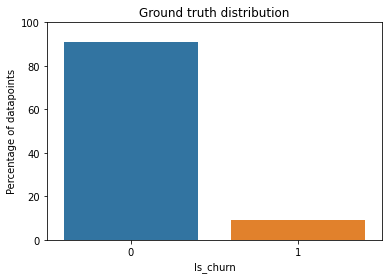

In [ ]:
## Ground truth distribution
sns.barplot(data=pd.DataFrame(model_data.is_churn.value_counts() /len(model_data) * 100).reset_index(), x='index', y='is_churn')
plt.ylim(0,100)
plt.title('Ground truth distribution')
plt.xlabel('Is_churn')
plt.ylabel('Percentage of datapoints')
plt.show()

In [ ]:
model_data.describe()

,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,registered_via,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,970960.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,860967.000000,860967.000000,860967.000000,754551.000000,754551.000000,754551.000000,754551.000000,754551.000000,754551.000000,7.545510e+05
mean,0.089942,38.891823,33.890672,145.022601,144.834126,0.911213,0.024371,5.937295,13.583854,6.892744,108.773786,26.257260,16.545723,18.713420,535.902252,511.878935,1.397844e+05
std,0.286099,3.799949,33.252966,140.161240,140.239977,0.284437,0.154197,6.441203,20.064040,1.937794,179.003032,38.707599,22.399375,41.691069,763.731803,594.729644,1.855241e+05
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3152.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.500000e-02
25%,0.000000,38.000000,30.000000,99.000000,99.000000,1.000000,0.000000,1.000000,0.000000,7.000000,19.000000,5.000000,3.000000,3.000000,108.000000,124.000000,3.020290e+04
50%,0.000000,41.000000,30.000000,149.000000,149.000000,1.000000,0.000000,1.000000,0.000000,7.000000,55.000000,14.000000,10.000000,10.000000,305.000000,330.000000,8.264024e+04
75%,0.000000,41.000000,30.000000,149.000000,149.000000,1.000000,0.000000,13.000000,27.000000,9.000000,133.000000,33.000000,22.000000,23.000000,660.000000,680.000000,1.757171e+05
max,1.000000,41.000000,450.000000,2000.000000,2000.000000,1.000000,1.000000,22.000000,2016.000000,13.000000,46820.000000,3163.000000,1310.000000,15164.000000,57675.000000,23403.000000,1.433739e+07


In [ ]:
model_data.dtypes

msno                       object
is_churn                    int64
payment_method_id         float64
payment_plan_days         float64
plan_list_price           float64
actual_amount_paid        float64
is_auto_renew             float64
transaction_date           object
membership_expire_date     object
is_cancel                 float64
city                      float64
bd                        float64
gender                     object
registered_via            float64
registration_init_time     object
num_25                    float64
num_50                    float64
num_75                    float64
num_985                   float64
num_100                   float64
num_unq                   float64
total_secs                float64
dtype: object

In [ ]:
## Percentage of NA values for each column
(model_data.isna()).mean() * 100

msno                       0.000000
is_churn                   0.000000
payment_method_id          3.850004
payment_plan_days          3.850004
plan_list_price            3.850004
actual_amount_paid         3.850004
is_auto_renew              3.850004
transaction_date           3.850004
membership_expire_date     3.850004
is_cancel                  3.850004
city                      11.328273
bd                        11.328273
gender                    59.946342
registered_via            11.328273
registration_init_time    11.328273
num_25                    22.288148
num_50                    22.288148
num_75                    22.288148
num_985                   22.288148
num_100                   22.288148
num_unq                   22.288148
total_secs                22.288148
dtype: float64

In [ ]:
## Number of records with atleast one NA
sum(model_data.isna().mean(axis=1) > 0)

627045

About 65% of records have atleast one NA value

## Univariate analysis

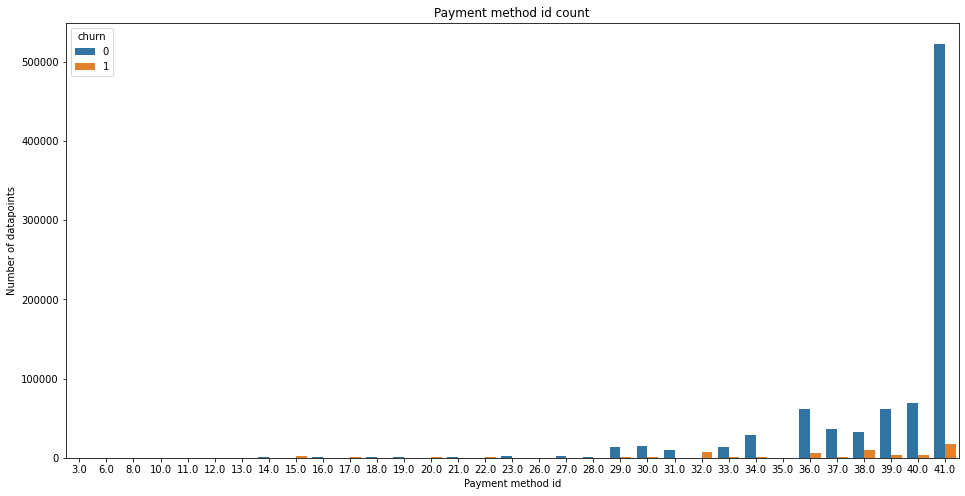

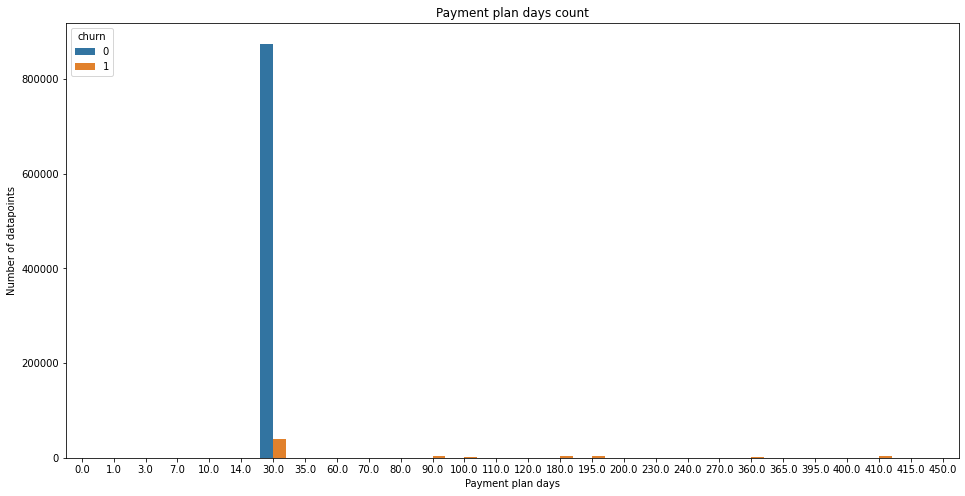

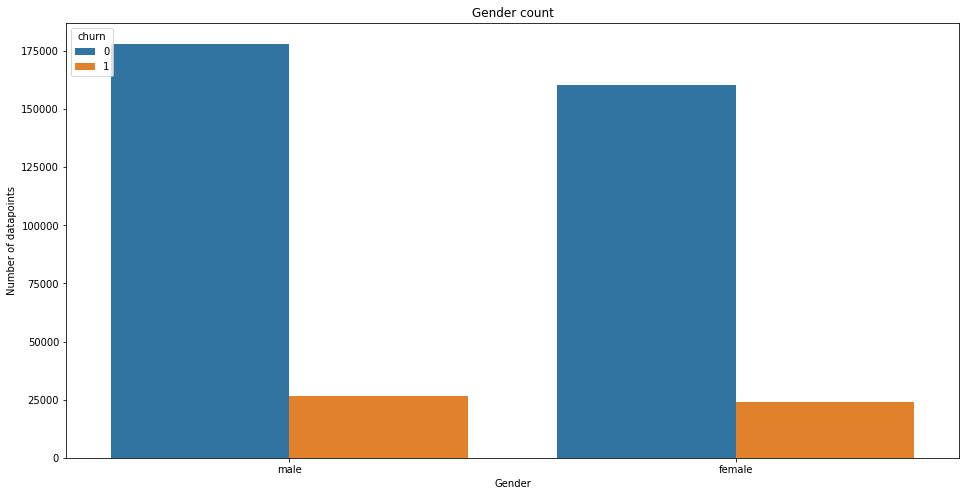

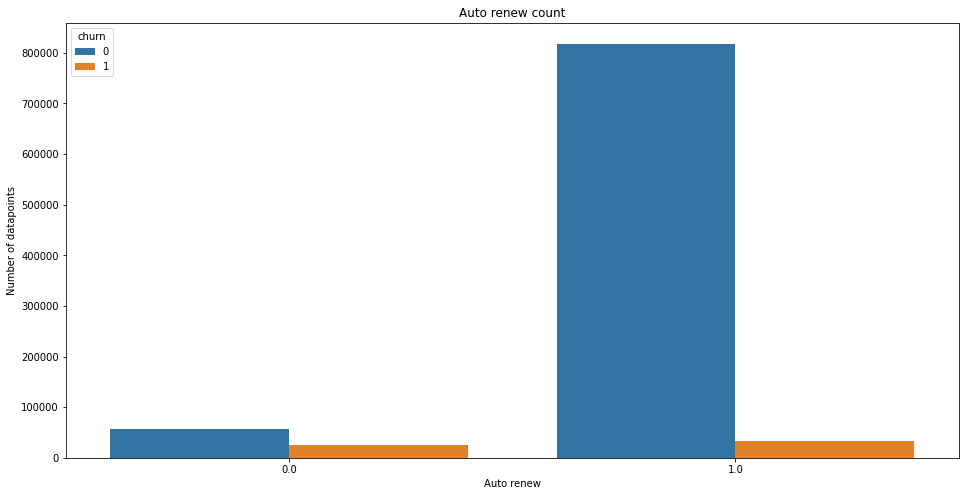

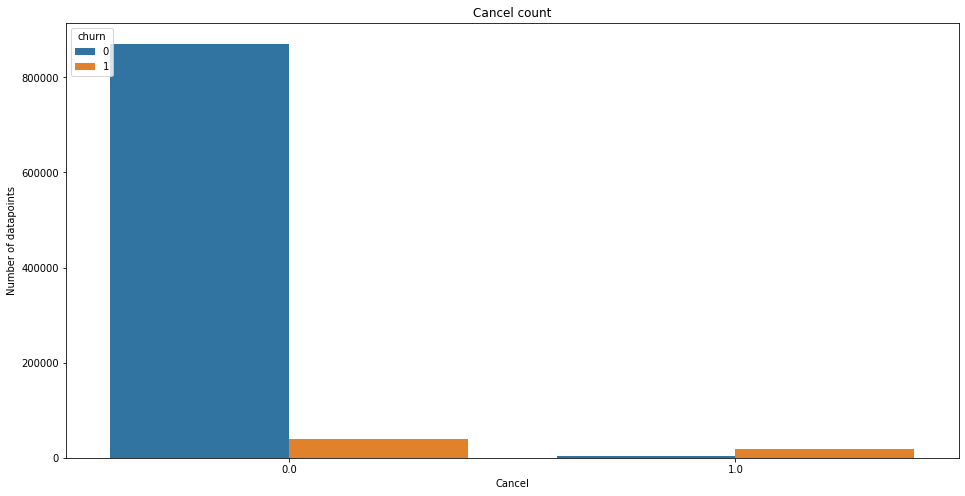

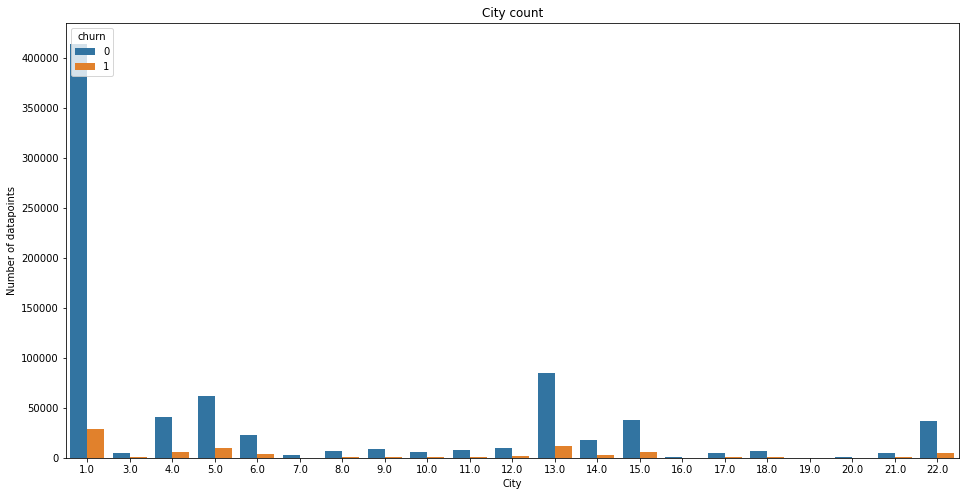

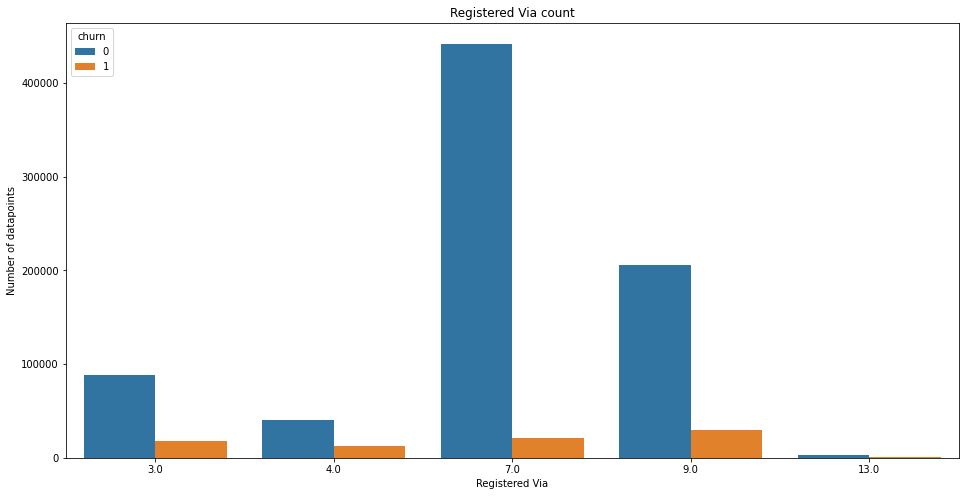

In [ ]:
## Count plots for categorical variables
columns = ['payment_method_id', 'payment_plan_days', 'gender', 'is_auto_renew', 'is_cancel', 'city', 'registered_via']
column_names = ['Payment method id', 'Payment plan days', 'Gender', 'Auto renew', 'Cancel', 'City', 'Registered Via']
hue_column = 'is_churn'
hue_legend = 'churn'

for n,col in enumerate(columns):
    ## Payment Method distribution
    plt.figure(figsize=(16,8))
    sns.countplot(x=col, hue=hue_column, data = model_data)
    plt.title(f'{column_names[n]} count')
    plt.xlabel(column_names[n])
    plt.ylabel('Number of datapoints')
    plt.legend(title=hue_legend, loc=2)
    plt.show()

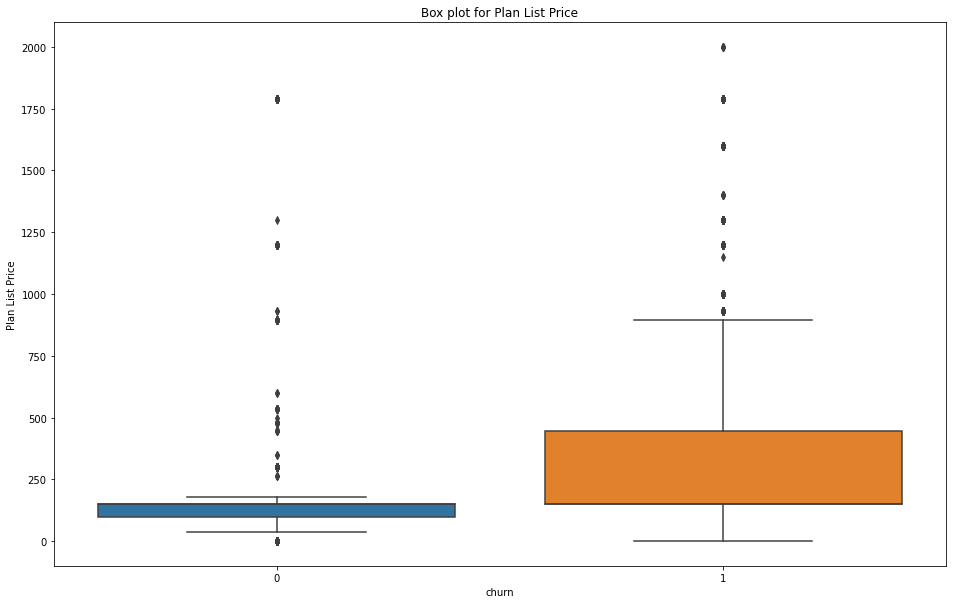

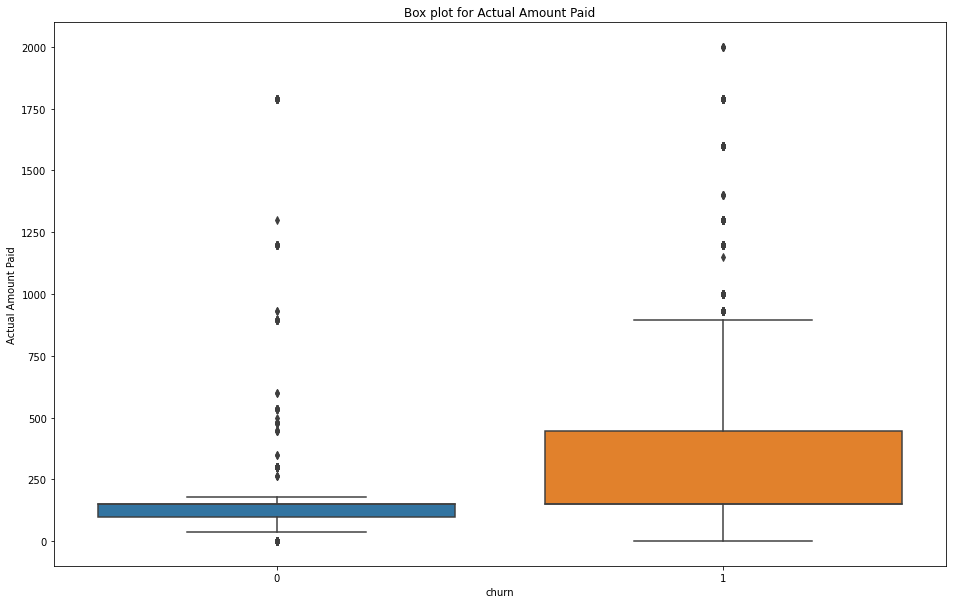

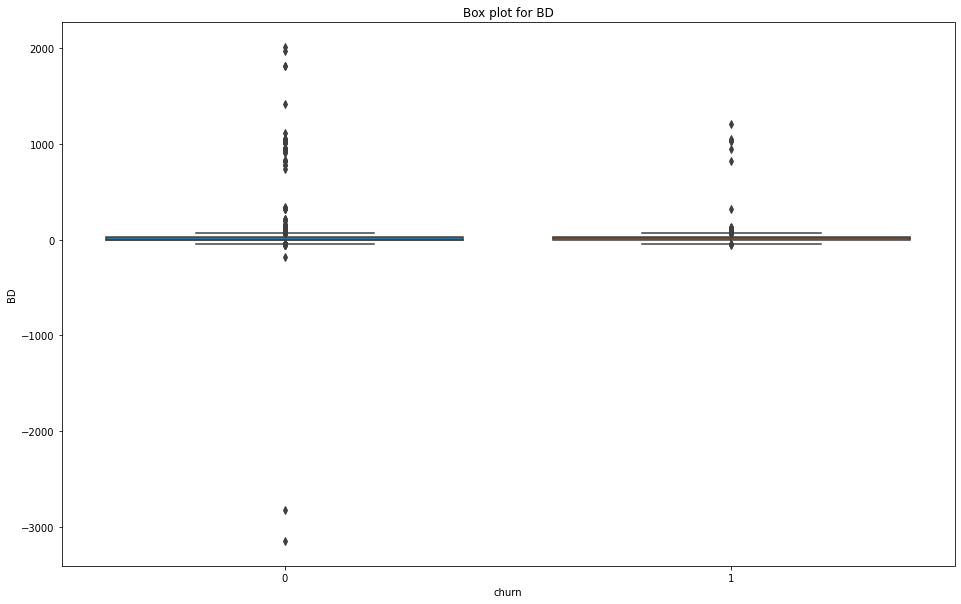

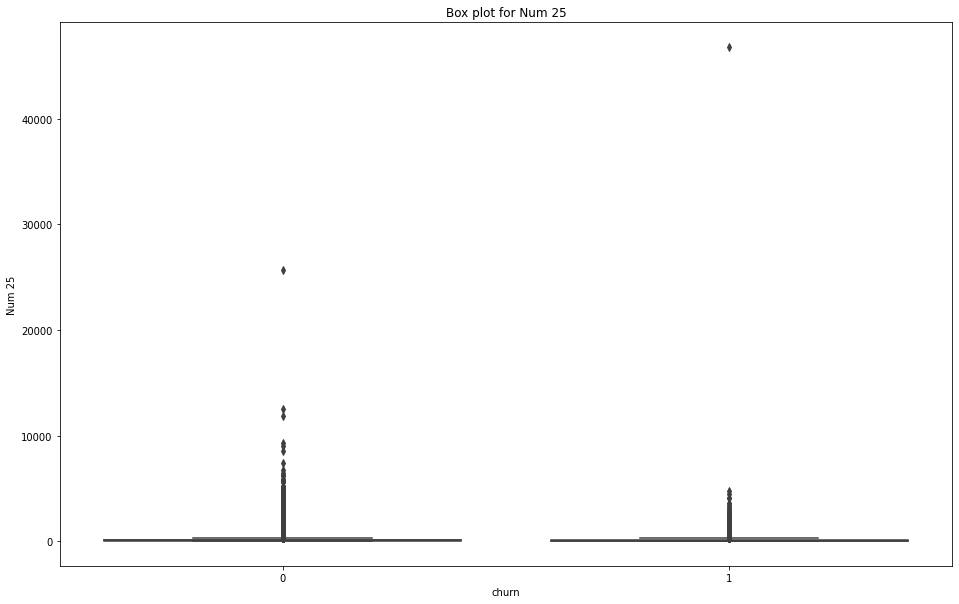

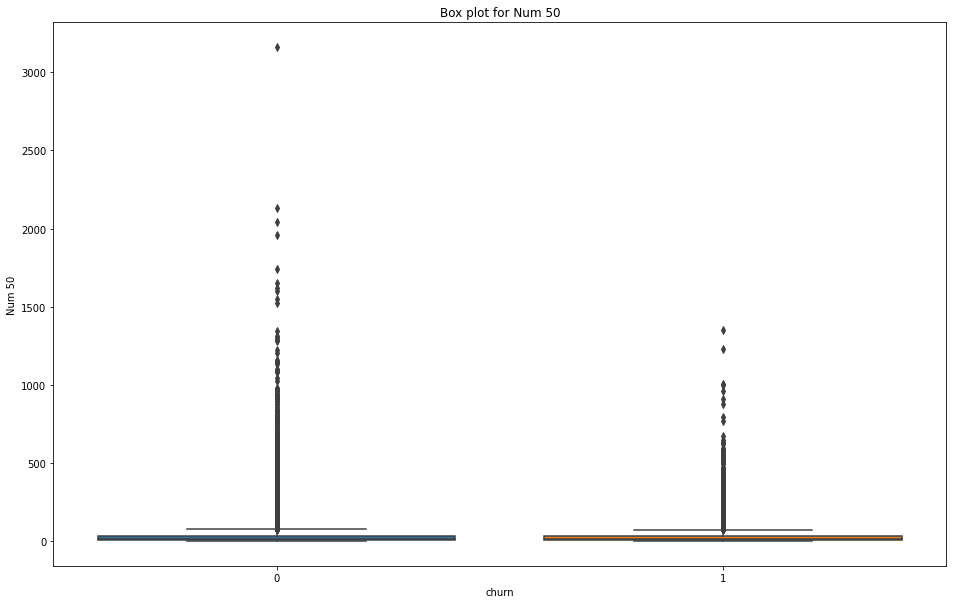

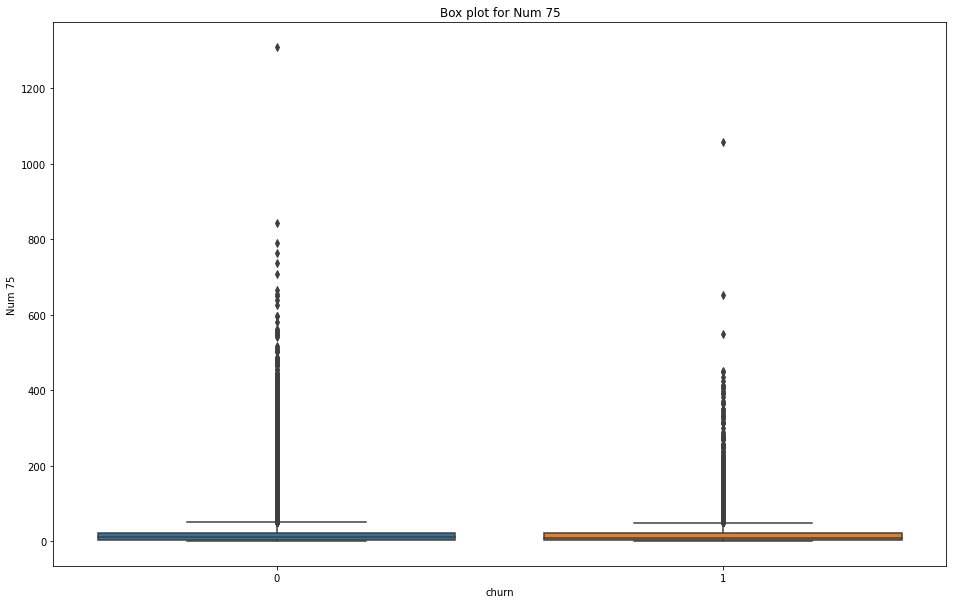

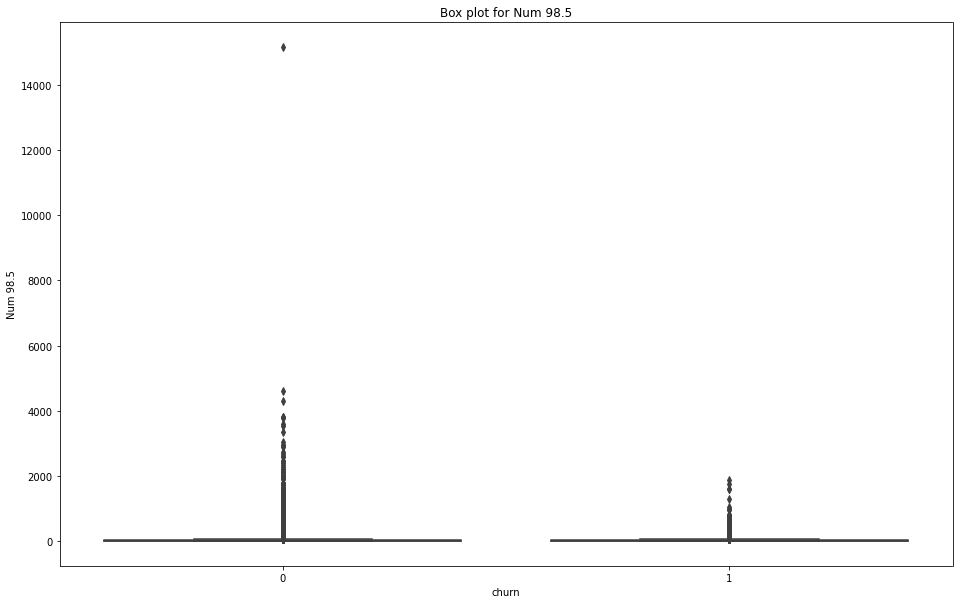

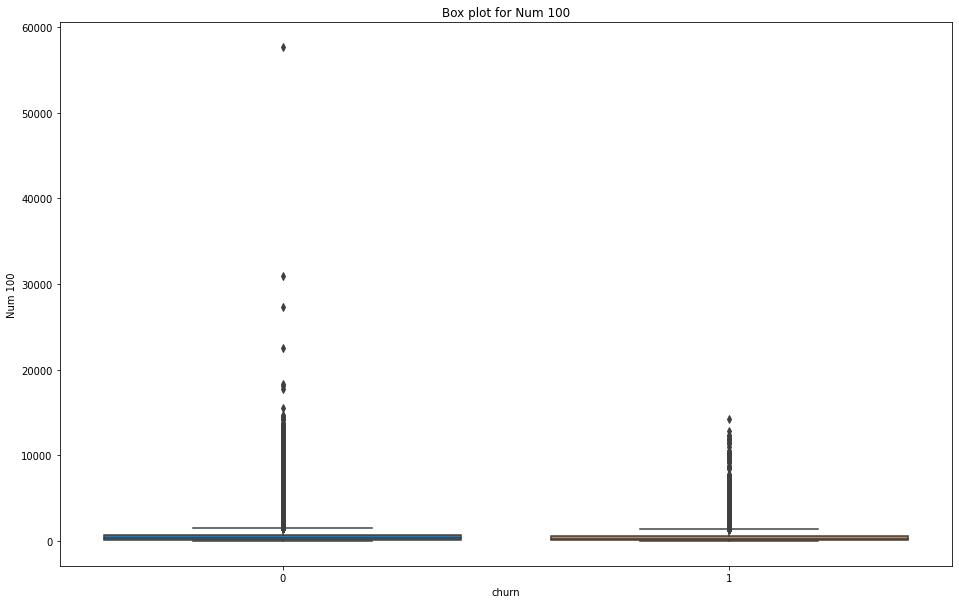

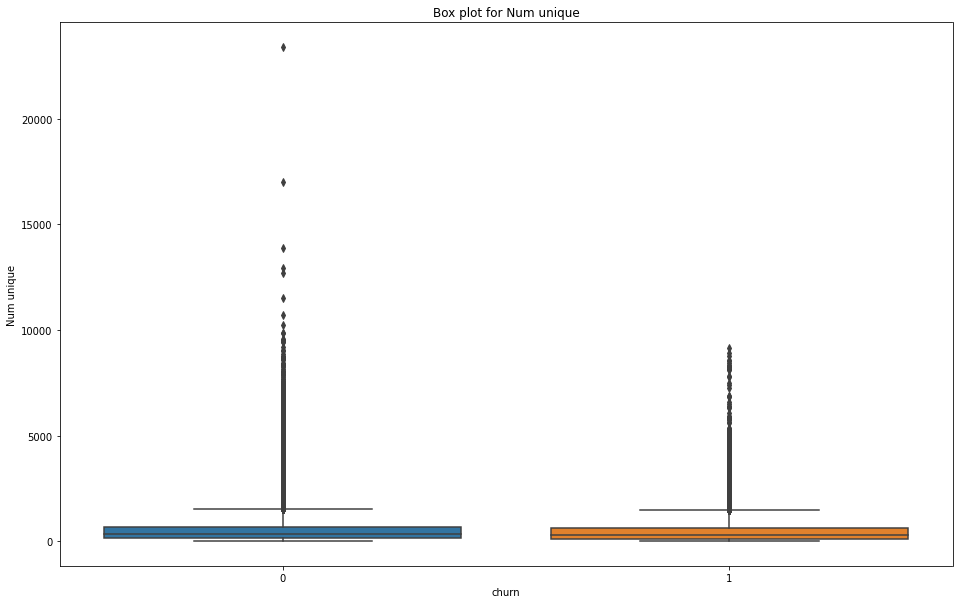

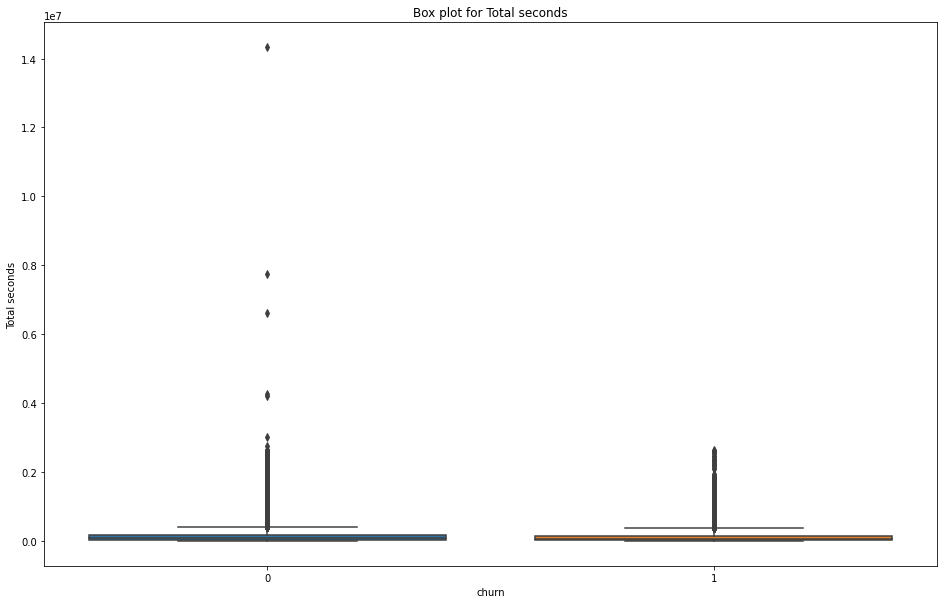

In [ ]:
## Boxplot for continuous variables
cont_columns = ['plan_list_price', 'actual_amount_paid', 'bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
cont_column_names = ['Plan List Price', 'Actual Amount Paid', 'BD', 'Num 25', 'Num 50', 'Num 75', 'Num 98.5', 'Num 100', 'Num unique', 'Total seconds']
hue_column = 'is_churn'
hue_legend = 'churn'

for n,col in enumerate(cont_columns):
    plt.figure(figsize=(16,10))
    sns.boxplot(x=hue_column, y=col, data=model_data)
    plt.title(f'Box plot for {cont_column_names[n]}')
    plt.ylabel(cont_column_names[n])
    plt.xlabel(hue_legend)
    plt.show()        

In [ ]:
## Pairwise plots
#sns.pairplot(model_data.loc[:, [col not in ['msno', 'transaction_date', 'membership_expire_date', 'registration_init_time'] for col in model_data.columns]], hue='is_churn')

In [ ]:
## Create train, val and test set
def create_train_val_test(dataset_size: int, train_val_test_size: tuple or list, rand_seed: int = 30):
    """
        Function to create train, validation, and test set

        Parameters
        ----------------
        dataset_size : int denoting the dataset size
        train_val_test_size : tuple or list representing the size of train, val, and test set

        Returns dict with indices for train, val and test sets
    """
    if not isinstance(dataset_size, int) or not isinstance(train_val_test_size, (tuple, list)):
        raise AssertionError("Dataset size must be an int. Train val test size must be a tuple or a list")
    
    ## Set random seed
    np.random.seed(rand_seed)

    ## Permute the order of dataset 
    permuted_index = np.random.permutation(np.arange(dataset_size))

    ## Compute final indices for train and val set
    train_max = int(train_val_test_size[0] * dataset_size)
    val_max = int((train_val_test_size[0] + train_val_test_size[1]) * dataset_size)

    ## Create a dict for train, val and test indices
    data_split_dict = dict()
    data_split_dict['train'] = list(permuted_index[:train_max])
    data_split_dict['val'] = list(permuted_index[train_max:val_max])
    data_split_dict['test'] = list(permuted_index[val_max:])

    return data_split_dict

In [ ]:
data_split = create_train_val_test(len(model_data), [0.75,0.15,0.1])

In [ ]:
## Split test data
test_data = model_data.loc[data_split['test']]

In [ ]:
## Filter rows which are part of test set
train_val_data = model_data.loc[data_split['train'] + data_split['val'],:]
train_val_data.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
684767,YSs/vsH+AL1WRvlkoLDGFT9wWihtQnqQZuKhqdcybm0=,0,40.0,30.0,149.0,149.0,1.0,2017-03-22,2017-04-22,0.0,18.0,0.0,NaN,9.0,2012-04-18,116.0,26.0,25.0,37.0,3541.0,2912.0,866766.109
251907,WxkFqbfXFSQgzlLld/tgOEFA9oGpf7JmPgsaMryCZWg=,0,41.0,30.0,149.0,149.0,1.0,2017-03-05,2017-04-05,0.0,4.0,40.0,female,7.0,2013-09-06,16.0,3.0,3.0,1.0,20.0,33.0,6766.055
544704,58GesZdrmqPIpKnmdzPnUpw07joB4w8ayPNVfhMPPY4=,0,40.0,30.0,149.0,149.0,1.0,2017-03-24,2017-04-24,0.0,10.0,35.0,male,9.0,2014-12-24,127.0,45.0,29.0,22.0,1305.0,1060.0,318577.925
23513,4LqpGjJ/MUOT3a0WEcSUI6xEykQACYUX0pCPm0xgVsg=,1,35.0,7.0,0.0,0.0,0.0,2017-02-20,2017-09-29,0.0,1.0,0.0,NaN,9.0,2014-12-04,45.0,5.0,7.0,11.0,528.0,560.0,137037.344
388035,limE8R97wWE+cNSl8CXf0CG/wmI4m1WaZQYPxcjz184=,0,41.0,30.0,149.0,149.0,1.0,2017-03-27,2017-04-27,0.0,1.0,0.0,NaN,7.0,2011-12-17,98.0,25.0,14.0,10.0,484.0,399.0,125289.625


In [ ]:
## Save Train-val and test data to csv
train_val_data.to_csv(folder_path.joinpath('train_val_data.csv'), index=False)
test_data.to_csv(folder_path.joinpath('test_data.csv'), index=False)